# **Focus Area 1 — Ground Observations Monitoring &amp; QC**
**Core Objective**: To equip NMHS participants with tools for quality-controlling ground station
data and validating it against satellite products, enabling identification of network issues and
building confidence in observational networks.

### **Overall notebook steps**
Set up
  - Step 1: Define variables to use in the analysis
  - Step 2: Setup – Install dependencies, authenticate Google Drive & Earth Engine

Data Extraction
  - Step 3: Visualise the area of interest
  - Step 4: Upload custom data or extract TAHMO data (Ground stations)
  - Step 5: Extract CHIRPS data

Data Processing
  - Step 6: Visualise data availability for ground stations and handle missing data

Data QC and comparison
  - Step 7: Aggregate the Ground data to Pentads
  - Step 8: Build CHIRPS Nearest data for the ground stations
  - Step 9: Visualise CHIRPS vs the Ground stations
  - Step 10: Compute station confidence scores

### **Station Scoring – Formula (0–100)**
We compute per-station metrics on **pentad totals** and convert them to a 0–100 score:

- **corr (r)** – higher is better
- **rmse** (mm/pentad) – lower is better
- **bias** (|gauge − CHIRPS|, mm/pentad) – lower is better
- **complete** – fraction of pentads that meet `MIN_PENTAD_DAYS` – higher is better
- **outlier** – fraction of pentads outside tolerance – lower is better

Weights are set in `SCORING_WEIGHTS` in the Config cell. The final score is:

```
score = 100 * [
  w_corr * norm_corr +
  w_rmse * (1 - norm_rmse) +
  w_bias * (1 - norm_bias) +
  w_complete * complete +
  w_outlier * (1 - outlier)
]
```
with simple min–max normalization of rmse/bias over stations.


### **Instructions to use custom data**

To use custom data you require 2 files
- The Metadata file: Ground_Metadata.csv
- The Ground_station data file: Ground_data.csv

**Recommended file format and structure (Columns)**:
<!DOCTYPE html>
<html>
<head>
    <title>Ground_Metadata.csv</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>lat</th>
            <th>lon</th>
        </tr>
        <tr>
            <td>Station1</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
    <p><p>
</html>

Data file format (Columns): Precipitation data for multiple stations
<html>
<head>
    <title>Ground_data.csv</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>Station1</th>
            <th>Station2</th>
            <th>Station3</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

# **Step 1: Define variables to use in the analysis**

In [72]:
## === CONFIG (edit here) ======================================================

import os, numpy as np
from datetime import date

# Define data source to be used for ground stations data
Ground_data_source = "custom" # use custom or TAHMO

# Country / ROI
COUNTRY = 'Kenya'            # 'Kenya' | 'Uganda' | 'Rwanda'
ROI_METHOD = 'OSM'           # 'OSM' (default) or 'GMAPS' if API key available

# Dates
start_date = '2025-04-01'    # ISO format
end_date   = '2025-05-31'

# Output directory (will be created under Google Drive if mounted)
RUN_STAMP = date.today().isoformat()
BASE_OUT = f'/content/drive/MyDrive/NOAA_QC_RUN_{COUNTRY}_{RUN_STAMP}'
os.makedirs(BASE_OUT, exist_ok=True)

# QC thresholds
QC_LIMITS = {
    'rain_min': 0.0,
    'rain_spike_mm': 300.0,    # flag if a single day exceeds this
    'flatline_days': 7,        # flag if >=N days unchanged
}

# Aggregation & matching
CHIRPS_AGG = 'pentad'        # currently pentad-based comparison
MIN_PENTAD_DAYS = 3          # minimum valid daily values to accept a pentad
NEIGHBORHOOD = 3             # 1 (nearest pixel), 3 or 5 for mean of NxN neighborhood

# Scoring weights (must sum to 1.0)
SCORING_WEIGHTS = {
    'corr': 0.35,   # Pearson r (higher is better)
    'rmse': 0.25,   # RMSE (lower is better)
    'bias': 0.15,   # absolute bias (lower is better)
    'complete': 0.20, # pentad completeness (higher is better)
    'outlier': 0.05,  # outlier rate (lower is better)
}

# Correlation method
CORR_METHOD='spearman' # Use pearson or spearman

# Confidence definition
High_confidence_threshold = "70"
Low_confidence_threshold = "30"

# Reproducibility
np.random.seed(42)
print('✅ CONFIG set. Outputs will be written to:', BASE_OUT)


✅ CONFIG set. Outputs will be written to: /content/drive/MyDrive/NOAA_QC_RUN_Kenya_2025-10-14


# **Step 2: Setup – Install dependencies, authenticate Google Drive & Earth Engine**

In [34]:
# @title ###2a) Install dependencies
# @markdown This cell installs the required dependencies for the workshop. It may take a few minutes <br>
# @markdown If you encounter any errors, please restart the runtime and try again. <br>
# @markdown If the error persists, please seek help.


print("Installing required dependencies...")
!pip install git+https://github.com/TAHMO/NOAA.git > /dev/null 2>&1
!pip install scipy --upgrade > /dev/null 2>&1 # Added to upgrade scipy

!jupyter nbextension enable --py widgetsnbextension

# check there was no error
import sys
if not sys.argv[0].endswith("kernel_launcher.py"):
    print("❌ Errors occurred during installation. Please restart the runtime and try again.")
else:
    print("✅ Dependencies installed successfully.")

print("Importing required libraries...")
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel

# import os
# os.chdir('NOAA-workshop')

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data, plot_xarray_data2
from google.colab import drive

%matplotlib inline

print("✅ Libraries imported successfully.")

Installing required dependencies...
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
✅ Dependencies installed successfully.
Importing required libraries...
✅ Libraries imported successfully.


In [6]:
# @title ### 2b) Authenticate Google Drive & Earth Engine {"display-mode":"form"}
# @markdown This step is used to authenticate you as a user and there will be two popups that will be doing this.
# @markdown 1. **Authentication to Google Drive** - This is where we shall be loading the data after we have extracted it
# @markdown 2. **Authentication to Google Earth Engine** - This will be used to extract the CHIRPS data and any other satellite product we shall be extracting in the future.
# @markdown Please check your email we shared an invitation to our Google Cloud Project that we shall be using to extract the data<br>
# @markdown *PS: In the future, to create your own project, please refer to [Google Cloud's Documentation](https://developers.google.com/earth-engine/guides/access) that shows the step by step breakdown of creating a Google Cloud Project and enabling Google Earth Engine*
# @markdown  Link to configure noncommercial use of Google Earth Engine: https://console.cloud.google.com/earth-engine/configuration <br><br>
# @markdown For this workshop, we have created the ```noaa-tahmo``` project that you can input as your project id<br><br><br>

print("Authenticating to Google Drive...")
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive', force_remount=True)
  print("✅ Google Drive authenticated successfully.")
else:
  print("✅ Google Drive already mounted.")

import ee

# Authenticate and initialise Google Earth Engine
# This will open a link in your browser to grant permissions if necessary.
try:
    print("Authenticating Google Earth Engine. Please follow the instructions in your browser.")
    ee.Authenticate()
    print("✅ Authentication successful.")
except ee.auth.scopes.MissingScopeError:
    print("Authentication scopes are missing. Please re-run the cell and grant the necessary permissions.")
except Exception as e:
    print(f"Authentication failed: {e}")

# Initialize Earth Engine with your project ID
# Replace 'your-project-id' with your actual Google Cloud Project ID
# You need to create an unpaid project manually through the Google Cloud Console
print("\nIf you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console")
print("💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id")
try:
    # It's recommended to use a project ID associated with your Earth Engine account.
    print("\nEnter your Google Cloud Project ID: ")
    project_id = input("")
    ee.Initialize(project=project_id)
    print("✅ Google Earth Engine initialized successfully.")
except ee.EEException as e:
    if "PERMISSION_DENIED" in str(e):
        print(f"Earth Engine initialization failed due to PERMISSION_DENIED.")
        print("Please ensure the Earth Engine API is enabled for your project:")
        print("Enable the Earth Engine API here: https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview?project=elated-capsule-471808-k1")
    else:
        print(f"Earth Engine initialization failed: {e}")
except Exception as e:
    print(f"An unexpected error occurred during initialization: {e}")

Authenticating to Google Drive...
✅ Google Drive already mounted.
Authenticating Google Earth Engine. Please follow the instructions in your browser.
✅ Authentication successful.

If you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console
💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id

Enter your Google Cloud Project ID: 
carbon-quanta-471808-i5
✅ Google Earth Engine initialized successfully.


In [7]:
# @title ### 2c) Loading helper functions {"display-mode":"form"}

# @markdown This cell loads helper functions for the Quality control section

# === HELPERS ================================================================
import numpy as np
import pandas as pd

def interquartile_mean(arr):
    """Return the mean of the central 50% (25th–75th percentile)."""
    a = np.sort(np.asarray(arr).astype(float))
    n = len(a)
    if n == 0:
        return np.nan
    lo = int(np.floor(0.25*n))
    hi = int(np.ceil(0.75*n))
    hi = max(hi, lo+1)
    return float(np.mean(a[lo:hi]))

def representative_member(arr):
    """Return value from arr closest to the interquartile mean."""
    iqm = interquartile_mean(arr)
    if np.isnan(iqm):
        return np.nan
    arr = np.asarray(arr).astype(float)
    return float(arr[np.argmin(np.abs(arr - iqm))])

def flag_qc(df, precip_col='precip'):
    """Add simple QC flags to a daily dataframe with a precipitation column."""
    out = df.copy()
    out['neg_rain'] = out[precip_col] < QC_LIMITS['rain_min']
    out['daily_spike'] = out[precip_col] > QC_LIMITS['rain_spike_mm']
    # flatline: same value N days in a row
    runs = (out[precip_col].diff()!=0).cumsum()
    run_lengths = runs.map(runs.value_counts())
    out['flatline_Ndays'] = run_lengths >= QC_LIMITS['flatline_days']
    return out

def qc_summary(df, station_col='station_id', date_col='date', precip_col='precip'):
    """Summarize QC flags per station."""
    grp = df.groupby(station_col)
    summ = grp.agg(
        n_obs=(precip_col, 'size'),
        n_missing=(precip_col, lambda s: int(s.isna().sum())),
        neg_rain=('neg_rain', 'sum'),
        daily_spike=('daily_spike', 'sum'),
        flatline=('flatline_Ndays', 'sum'),
    ).reset_index()
    summ['missing_pct'] = (summ['n_missing'] / summ['n_obs']).round(3)
    return summ

def classify_score(s):
    if s >= 70: return 'High'
    if s >= 50: return 'Medium'
    return 'Low'

print('✅ Helpers loaded')


✅ Helpers loaded


In [8]:
# @title ###2d) Please run this cell and upload the provided config file {"display-mode":"form"}
# @markdown A config file is provided for this workshop with the api keys to access TAHMO Data
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"✅ File '{file_name}' uploaded successfully.")

# Loading the config file and parsing from uploaded incase it comes with a different name
import json
with open(file_name, 'r') as f:
    config = json.load(f)

Saving config.json to config.json
✅ File 'config.json' uploaded successfully.


# **Step 3: Visualise the area of interest**

In [9]:
# @title ####The Google Maps API will be used to fetch geometry, bounding box, and show the polygon on a map. {"display-mode":"form"}

import time
import json
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Polygon
import sys
import importlib

# --- Environment Detection ---
def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

IS_COLAB = in_colab()
print(f"💡 Running in {'Google Colab' if IS_COLAB else 'Local Jupyter'} environment.")

try:
    with open('/content/config.json', 'r') as f:
        config = json.load(f)
    location_key = config.get('location_keys', None)
except Exception:
    location_key = None
    print("⚠️ Warning: No API key found. Fallback modes will be used.")

def xmin_ymin_xmax_ymax(polygon):
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    return min(lons), min(lats), max(lons), max(lats)

def fetch_region_google(query):
    """Primary: Fetch polygon geometry via Google Maps API"""
    if not location_key:
        raise RuntimeError("Missing Google Maps API key.")
    region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
    return region_geom

def fetch_region_osm(query):
    """Fallback: Fetch geometry from OSM (Nominatim) via GeoPandas"""
    url = f"https://nominatim.openstreetmap.org/search?country={query}&format=geojson&polygon_geojson=1"
    gdf = gpd.read_file(url)
    if gdf.empty:
        raise ValueError("No OSM data found for that query.")
    geom = gdf.iloc[0].geometry
    if geom.geom_type == "Polygon":
        return list(geom.exterior.coords)
    elif geom.geom_type == "MultiPolygon":
        return list(list(geom.geoms)[0].exterior.coords)
    else:
        raise ValueError("Unsupported geometry type from OSM.")

def draw_region_interactively():
    """Manual fallback: let the user draw their ROI"""
    print("🖱️ Draw your region on the map (double-click to finish).")

    if IS_COLAB:
        # ✅ Folium backend (Colab-compatible)
        import geemap.foliumap as geemap
        from geemap.foliumap import plugins

        m = geemap.Map(center=[0, 20], zoom=3)
        draw = plugins.Draw(export=True)
        draw.add_to(m)
        m.add_child(plugins.Fullscreen())
        m.add_child(plugins.MeasureControl(primary_length_unit='kilometers'))
        m  # Display map in Colab output cell

        print("✅ Use the draw tools on the left to mark your region.")
        print("💾 After drawing, click 'Export' to download your GeoJSON.")
        return m

    else:
        # ✅ ipyleaflet backend (Local Jupyter)
        import geemap
        m = geemap.Map(center=[0, 20], zoom=3)
        m.add_draw_control()
        display(m)
        print("✅ After drawing, access your shape via `m.user_rois`.")
        return m


def show_region_plotly(polygon, region_name="Region", margin=0.05):
    """Plot polygon with Plotly Mapbox"""
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    fig = go.Figure(go.Scattermapbox(
        lon=lons + [lons[0]],
        lat=lats + [lats[0]],
        mode="lines",
        fill="toself",
        fillcolor="rgba(0,0,255,0.3)",
        name=region_name
    ))
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox=dict(center={"lat": sum(lats)/len(lats), "lon": sum(lons)/len(lons)}, zoom=5),
        margin=dict(r=0, t=30, l=0, b=0),
        title=f"Region of Interest: {region_name}",
        height=500,
        width=900
    )
    fig.show()
    return fig

time.sleep(1) # avoid jumps in the input
region_query = COUNTRY

region_geom = None
try:
    region_geom = fetch_region_google(region_query)
    print(f"✅ Geometry fetched via Google Maps API for {region_query}")
except Exception as e1:
    print(f"⚠️ Google Maps API failed: {e1}")
    try:
        region_geom = fetch_region_osm(region_query)
        print(f"✅ Geometry fetched via OpenStreetMap for {region_query}")
    except Exception as e2:
        print(f"⚠️ OSM fallback failed: {e2}")
        print("🔁 Launching interactive map draw mode...")
        map_widget = draw_region_interactively()

if region_geom:
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    show_region_plotly(region_geom, region_name=region_query)
    print(f"📦 Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
else:
    print("🛑 No geometry available. Please draw manually or retry another query.")

region_query = region_query.lower()


💡 Running in Google Colab environment.
✅ Geometry fetched via Google Maps API for Kenya


📦 Bounding box -> xmin: 33.90982109999999, ymin: -4.724299999999999, xmax: 41.90684160000001, ymax: 5.033420899999999


# **Step 4: Upload custom data or extract TAHMO data (Ground stations)**

In [10]:
# @title ### 4a_1: Extract and visualise TAHMO data using filter stations

# @markdown ❌ SKIP this step if you have your own data

# @markdown Documentation: https://filter-stations.netlify.app/

# @markdown Using the method ```get_stations_info()``` to extract the metadata and ```multiple_measurements()``` to extract the precipitation data from multiple stations

# @markdown At this step we shall also create a directory to start storing the datasets we keep on extracting on Google Drive to easily access and minimize API requests<br>


from utils.filter_stations import RetrieveData
import os
import time

dir_path = '/content/drive/MyDrive/NOAA-workshop-data'
os.makedirs(dir_path, exist_ok=True)
# check if the path was created successfully
if not os.path.exists(dir_path):
    print("❌ Path not created successfully.")
else:
    print("✅ Path created successfully.")

# check if the config exists
if not os.path.exists('/content/config.json'):
    print("❌ Config file not found. Please upload it first.")

import plotly.express as px
import pandas as pd

def plot_stations_plotly(dataframes, colors=None, zoom=5, height=500,
                         width=900, legend_title='Station Locations'):
    """
    Plot stations from one or more dataframes on a Plotly mapbox.

    Each dataframe must have 'location.latitude' and 'location.longitude' columns.
    'colors' is a list specifying marker colors for each dataframe respectively.
    """
    if colors is None:
        colors = ["blue", "red", "green", "purple", "orange"]

    frames = []
    for i, df in enumerate(dataframes):
        temp = df.copy()
        temp["color"] = colors[i % len(colors)]  # cycle colors if more dfs than colors
        frames.append(temp)

    combined = pd.concat(frames, ignore_index=True)

    fig = px.scatter_mapbox(
        combined,
        lat="location.latitude",
        lon="location.longitude",
        color="color",
        hover_name="code",
        zoom=zoom,
        height=height,
        width=width
    )

    fig.update_layout(
        mapbox_style="open-street-map",
        legend_title=legend_title,
        margin={"r": 0, "t": 30, "l": 0, "b": 0}
    )

    return fig



api_key = config['apiKey']
api_secret = config['apiSecret']

# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)

# Extracting TAHMO data
print("Extracting TAHMO data...")
info = rd.get_stations_info()
info = info[(info['location.longitude'] >= xmin) &
                        (info['location.longitude'] <= xmax) &
                        (info['location.latitude'] >= ymin) &
                        (info['location.latitude'] <= ymax)]
print("✅ TAHMO data extracted successfully.")
# Print the total number of stations
print(f"Total number of stations: {len(info)}")


# save the data as csv to the created directory
info.to_csv(f'{dir_path}/Ground_Metadata.csv')

# wait for 5 seconds before visual
time.sleep(5)

# Visualise the data
plot_stations_plotly([info], colors=["blue"])

✅ Path created successfully.
Extracting TAHMO data...
✅ TAHMO data extracted successfully.
Total number of stations: 190


In [13]:
# @title ### 4a_2: Extracting TAHMO Precipitation data and preview
# @markdown Using filter-stations to extract precipitation data <br>
# @title ### 4a_1: Extract and visualise TAHMO data using filter stations

# @markdown ❌ SKIP this step if you have your own data

# save to the directory

# print('Extracting Precipitation Data ...')
region_precip = rd.multiple_measurements(stations_list=info['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['pr'],
                                         csv_file=f'{dir_path}/Ground_data')

# check if the file exist to know if it was successful
if not os.path.exists(f'{dir_path}/Ground_data.csv'):
    print("❌ Precipitation data not extracted successfully.")
else:
    print("✅ Precipitation data extracted successfully.")

# Visualise any random station data
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

# plot_stations_data_randomly(region_precip)

region_precip

Retrieving data for stations:   0%|          | 0/190 [00:00<?, ?it/s]

✅ Precipitation data extracted successfully.


,TA00001,TA00018,TA00019,TA00020,TA00021,TA00022,TA00023,TA00024,TA00025_S000116,TA00025_S002905,...,TA00880,TA00884,TA00903_S002980,TA00903_S002979,TA00907,TA00909,TD00001,TD00002,TD00004,TD00005
2025-04-01 00:00:00+00:00,0.000,0.204,0.748,0.051,0.068,NaN,NaN,0.068,0.000,NaN,...,2.058,0.000,NaN,NaN,NaN,NaN,19.77,0.00,0.00,NaN
2025-04-02 00:00:00+00:00,0.068,0.187,0.051,0.017,0.017,NaN,NaN,0.034,6.400,NaN,...,0.000,0.000,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN
2025-04-03 00:00:00+00:00,0.000,0.153,0.000,1.343,0.000,NaN,NaN,0.749,1.055,NaN,...,26.300,0.187,NaN,NaN,NaN,NaN,0.00,1.03,0.53,NaN
2025-04-04 00:00:00+00:00,18.485,0.136,2.839,0.833,8.450,NaN,NaN,6.446,0.017,NaN,...,0.000,0.000,NaN,NaN,NaN,NaN,0.05,0.01,1.65,NaN
2025-04-05 00:00:00+00:00,3.198,0.136,0.595,0.255,0.391,NaN,NaN,0.000,0.000,NaN,...,15.214,11.029,NaN,NaN,NaN,NaN,1.38,7.35,14.30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27 00:00:00+00:00,0.544,4.066,0.289,0.136,7.150,NaN,NaN,NaN,NaN,0.0,...,NaN,0.000,2.8,2.844,NaN,NaN,2.17,NaN,3.70,NaN
2025-05-28 00:00:00+00:00,0.221,5.460,0.187,0.000,0.119,NaN,NaN,NaN,NaN,0.0,...,NaN,0.017,0.6,0.500,NaN,NaN,0.52,NaN,0.66,NaN
2025-05-29 00:00:00+00:00,0.187,3.472,0.102,0.000,0.493,NaN,NaN,NaN,NaN,2.4,...,NaN,0.000,1.0,1.000,NaN,NaN,2.45,NaN,1.00,NaN
2025-05-30 00:00:00+00:00,0.136,10.049,0.034,0.017,1.938,NaN,NaN,0.000,NaN,0.0,...,NaN,0.000,2.0,1.900,NaN,NaN,17.51,NaN,1.92,NaN


In [26]:
# @title ### 4b_1) Upload custom data {"display-mode":"form"}
# @markdown ❌ SKIP this step if you are using TAHMO data

# @markdown Please upload your Ground_Metadata.csv and Ground_data.csv files.

from google.colab import files
import pandas as pd
import os

dir_path = '/content/drive/MyDrive/NOAA-workshop-data'
os.makedirs(dir_path, exist_ok=True)

# check if the path was created successfully
if not os.path.exists(dir_path):
    print("❌ Path not created successfully.")
else:
    print("✅ Path created successfully.")

# Delete existing files if they exist
metadata_path = os.path.join(dir_path, 'Ground_Metadata.csv')
data_path = os.path.join(dir_path, 'Ground_data.csv')

if os.path.exists(metadata_path):
    os.remove(metadata_path)

if os.path.exists(data_path):
    os.remove(data_path)

# Change working directory to the target path
os.chdir(dir_path)
print(f"✅ Working directory set to: {os.getcwd()}")

# Upload Ground_Metadata.csv
print("\nPlease upload Ground_Metadata.csv:")
uploaded_metadata = files.upload()
if not uploaded_metadata:
    print("❌ No file uploaded for Ground_Metadata.csv")
    metadata_file_name = None
else:
    metadata_file_name = list(uploaded_metadata.keys())[0]
    # Rename if needed
    if metadata_file_name != 'Ground_Metadata.csv':
        os.rename(metadata_file_name, 'Ground_Metadata.csv')
        metadata_file_name = 'Ground_Metadata.csv'
    print(f"✅ File saved as 'Ground_Metadata.csv'")


# Upload Ground_data.csv
print("\nPlease upload Ground_data.csv:")
uploaded_data = files.upload()
if not uploaded_data:
    print("❌ No file uploaded for Ground_data.csv.")
    data_file_name = None
else:
    data_file_name = list(uploaded_data.keys())[0]
    # Rename if needed
    if data_file_name != 'Ground_data.csv':
        os.rename(data_file_name, 'Ground_data.csv')
        data_file_name = 'Ground_data.csv'
    print(f"✅ File saved as 'Ground_data.csv'")


# --- Validation ---

region_metadata = None
region_precip_data = None

# Validate Ground_Metadata.csv if uploaded
if metadata_file_name:
    try:
        region_metadata = pd.read_csv(metadata_file_name)
        required_metadata_cols = ['Code', 'lat', 'lon']
        if not all(col in region_metadata.columns for col in required_metadata_cols):
            print(f"❌ Error: Ground_Metadata.csv must contain the columns: {required_metadata_cols}")
            region_metadata = None
        else:
            print("✅ Ground_Metadata.csv columns validated.")
            # Rename columns to match expected format later in the notebook
            region_metadata = region_metadata.rename(columns={'Code': 'code'})

    except Exception as e:
        print(f"❌ Error reading Ground_Metadata.csv: {e}")
        region_metadata = None

# Validate Ground_data.csv if uploaded
if data_file_name:
    try:
        region_precip_data = pd.read_csv(data_file_name)
        if 'Date' not in region_precip_data.columns:
            print("❌ Error: Ground_data.csv must contain a 'Date' column.")
            region_precip_data = None
        else:
            print("✅ Ground_data.csv 'Date' column validated.")

    except Exception as e:
        print(f"❌ Error reading Ground_data.csv: {e}")
        region_precip_data = None


# Display number of stations if data is loaded
if region_precip_data is not None:
    # Assuming all columns except 'Date' are stations
    station_columns = [col for col in region_precip_data.columns if col != 'Date']
    print(f"\nTotal number of stations in Ground_data.csv: {len(station_columns)}")

✅ Path created successfully.
🗑️ Deleted existing /content/drive/MyDrive/NOAA-workshop-data/Ground_Metadata.csv
🗑️ Deleted existing /content/drive/MyDrive/NOAA-workshop-data/Ground_data.csv
✅ Working directory set to: /content/drive/MyDrive/NOAA-workshop-data

Please upload Ground_Metadata.csv:


Saving Ground_Metadata.csv.csv to Ground_Metadata.csv (1).csv
✅ File saved as 'Ground_Metadata.csv'

Please upload Ground_data.csv:


Saving Ground_data.csv.csv to Ground_data.csv.csv
✅ File saved as 'Ground_data.csv'
✅ Ground_Metadata.csv columns validated.
✅ Ground_data.csv 'Date' column validated.

Total number of stations in Ground_data.csv: 2


In [32]:
# @title ### 4b_2) Visualise and preview custom data {"display-mode":"form"}
# @markdown ❌ SKIP this step if you are using TAHMO data

# @markdown Please upload your Ground_Metadata.csv and Ground_data.csv files.

import plotly.express as px
import pandas as pd

def plot_stations_plotly(dataframes, colors=None, zoom=5, height=500,
                         width=900, legend_title='Station Locations'):
    """
    Plot stations from one or more dataframes on a Plotly mapbox.

    Each dataframe must have 'lat' and 'lon' columns.
    'colors' is a list specifying marker colors for each dataframe respectively.
    """
    if colors is None:
        colors = ["blue", "red", "green", "purple", "orange"]

    frames = []
    for i, df in enumerate(dataframes):
        temp = df.copy()
        temp["color"] = colors[i % len(colors)]  # cycle colors if more dfs than colors
        frames.append(temp)

    combined = pd.concat(frames, ignore_index=True)

    fig = px.scatter_mapbox(
        combined,
        lat="lat",
        lon="lon",
        color="color",
        hover_name="Code",
        zoom=zoom,
        height=height,
        width=width
    )

    fig.update_layout(
        mapbox_style="open-street-map",
        legend_title=legend_title,
        margin={"r": 0, "t": 30, "l": 0, "b": 0}
    )

    return fig

# Load the custom data files
try:
    region_metadata = pd.read_csv('/content/drive/MyDrive/NOAA-workshop-data/Ground_Metadata.csv')
    region_precip_data = pd.read_csv('/content/drive/MyDrive/NOAA-workshop-data/Ground_data.csv')

    # Display the first 5 rows of the ground data
    print("Preview of first 5 rows of Ground_data.csv:")
    display(region_precip_data.head())

    # Visualise the custom metadata
    print("\nVisualizing custom station locations:")

    # Check if metadata is loaded and has required columns and data
    if region_metadata is None or region_metadata.empty or not all(col in region_metadata.columns for col in ['lat', 'lon']):
        print("❌ Metadata not loaded correctly or is empty or missing 'lat' or 'lon' columns. Please check your Ground_Metadata.csv file.")
    elif region_metadata[['lat', 'lon']].isnull().any().any():
         print("❌ Metadata contains missing latitude or longitude values. Please check your Ground_Metadata.csv file.")
    else:
        fig = plot_stations_plotly([region_metadata], colors=["blue"])
        fig.show()


except FileNotFoundError:
    print("❌ Custom data files not found. Please upload Ground_Metadata.csv and Ground_data.csv")
except Exception as e:
    print(f"❌ An error occurred while processing custom data: {e}")

Preview of first 5 rows of Ground_data.csv:


,Date,TA00024,TA00025
0,01/01/2025 00:00,0.0,0.0
1,01/01/2025 00:05,0.0,0.0
2,01/01/2025 00:10,0.0,0.0
3,01/01/2025 00:15,0.0,0.0
4,01/01/2025 00:20,0.0,0.0



Visualizing custom station locations:


# **Step 5: Extract CHIRPS data**

In [39]:
# @title ### Extract the data from Google Earth engine project

# @markdown **Note**: For this workshop, we have done this process for you when we shared the Google Cloud invitation to the project

# --- 4. Convert downloaded tiffs to xarray ---

import geemap
import glob
from tqdm.notebook import tqdm

# Define region of interest (Kenya)
roi = ee.Geometry.Polygon(region_geom)

# --- 2. Set up CHIRPS collection ---
collection_id = "UCSB-CHG/CHIRPS/PENTAD"
chirps = ee.ImageCollection(collection_id).filterDate(start_date, end_date).select("precipitation")
chirps = chirps.map(lambda img: img.clip(roi))

export_dir = "chirps_temp"
os.makedirs(export_dir, exist_ok=True)

# Convert to Python list
image_list = chirps.toList(chirps.size())
n_images = image_list.size().getInfo()

# --- 3. Download with progress bar ---
pbar = tqdm(total=n_images, desc="Exporting CHIRPS", unit="file")

for i in range(n_images):
    img = ee.Image(image_list.get(i))
    date_str = img.date().format("yyyyMMdd").getInfo()
    out_file = os.path.join(export_dir, f"{date_str}.tif")

    geemap.ee_export_image(
        img,
        filename=out_file,
        scale=5500,
        region=roi
    )

    pbar.update(1)
    pbar.refresh()  # force redraw in Colab

pbar.close()

# --- 4. Convert downloaded tiffs to xarray ---
tiff_files = sorted(glob.glob(os.path.join(export_dir, "*.tif")))
ds = xr.open_mfdataset(tiff_files, combine="nested", concat_dim="time", engine="rasterio")

dates = [os.path.basename(f).split(".")[0] for f in tiff_files]
ds = ds.assign_coords(time=pd.to_datetime(dates, format="%Y%m%d"))
ds = ds.squeeze("band", drop=True).rename({"band_data": "precipitation"})
ds.rio.write_crs("EPSG:4326", inplace=True)

# --- 5. Save as NetCDF ---
export_path = f'{dir_path}/chirps_pentad_{region_query}.nc'
ds.to_netcdf(export_path)

# --- 6. Clean data (remove imputed values) ---
chirps_ds = ds.where(ds != -9999)




Exporting CHIRPS:   0%|          | 0/12 [00:00<?, ?file/s]

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250401.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250406.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250411.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250416.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250421.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250426.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250501.tif
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/NOAA-workshop-data/chirps_temp/20250506.tif
Generating URL ...
Please wait .

# **Step 6: Visualise data availability for ground stations and handle missing data**


In [44]:
# @title ### 6a) Load the extracted CHIRPS and Ground Precipitation and Metadata

# from scipy.stats import pearsonr, ttest_rel
# handle runtime disconnected issues to begin from this step
# 1. check if region query is defined
if not 'region_query' in locals():
    region_query = input("🌍 It seems the runtime was disconnected please enter the region you had selected again: ")
    print('Re-Installing required dependencies ...')
    !pip install git+https://github.com/TAHMO/NOAA.git > /dev/null 2>&1
    import xarray as xr
    import time
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    # import ee
    import numpy as np
    # check if config.json file is already available
    if not os.path.exists('/content/config.json'):
      from google.colab import files
      # Upload the TAHMO config file
      print('Please upload the config file provided ...')
      uploaded = files.upload()

    # load the config.json file
    with open('/content/config.json', 'r') as f:
        config = json.load(f)

    location_key = config['location_keys']  # Google Maps API key
    api_key = config['apiKey']
    api_secret = config['apiSecret']


    time.sleep(2)
    # region_query = input("🌍 It seems the runtime was disconnected please write your region you had put againe: ")
    # print(f"Selected: {region_query}")
    # region_query = region_query.lower()

    # re importing the modules


    # import os
    # os.chdir('NOAA-workshop')


    from utils.ground_stations import plot_stations_folium
    from utils.helpers import get_region_geojson
    from utils.CHIRPS_helpers import get_chirps_pentad_gee
    from utils.plotting import plot_xarray_data, plot_xarray_data2
    from utils.filter_stations import RetrieveData

    from google.colab import drive

    def xmin_ymin_xmax_ymax(polygon):
      lons = [pt[0] for pt in polygon]
      lats = [pt[1] for pt in polygon]
      return min(lons), min(lats), max(lons), max(lats)

    def fetch_region(query):
      """Fetch polygon geometry and bounding box for region name"""
      region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
      xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
      print(f"✅ Selected: {query}")
      print(f"Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
      return region_geom, (xmin, ymin, xmax, ymax)

    # remounting drive
    drive.mount('/content/drive', force_remount=True)
    # check if the drve folder is available in /content/drive
    if not os.path.exists('/content/drive/MyDrive/NOAA-workshop-data'):
      print("❌ Google Drive not mounted successfully.")
    else:
      print("✅ Google Drive mounted successfully.")

    rd = RetrieveData(api_key,
                    api_secret)

    region_geom, bbox = fetch_region(region_query)

    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)

    dir_path = '/content/drive/MyDrive/NOAA-workshop-data'

    # check if the metadata, chirps and precip data is available
    if not os.path.exists(f'{dir_path}/tahmo_precip_{region_query}.csv'):
      print("❌ Precipitation data not extracted successfully.")
    else:
      print("✅ Precipitation data extracted successfully.")

    if not os.path.exists(f'{dir_path}/tahmo_metadata_{region_query}.csv'):
      print("❌ Metadata not extracted successfully.")
    else:
      print("✅ Metadata extracted successfully.")

    if not os.path.exists(f'{dir_path}/chirps_pentad_{region_query}.nc'):
      print("❌ CHIRPS data not extracted successfully.")
    else:
      print("✅ CHIRPS data extracted successfully.")

import xarray as xr
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
region_precip_data = pd.read_csv(f'{dir_path}/Ground_data.csv')
# eac metadata
region_metadata = pd.read_csv(f"{dir_path}/Ground_Metadata.csv")
if Ground_data_source.lower() == 'tahmo':
  region_metadata = region_metadata[['code', 'location.latitude', 'location.longitude']].rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})
elif Ground_data_source.lower() == 'custom':
  region_metadata = region_metadata.rename(columns={'Code': 'code'})
  region_metadata = region_metadata[['code', 'lat', 'lon']]
  # Rename the date column for consistency
  region_precip_data = region_precip_data.rename(columns={"Date": "Unnamed: 0"})


# CHIRPS Xarray dataset
chirps_ds = xr.open_dataset(f'{dir_path}/chirps_pentad_{region_query}.nc')
chirps_ds = chirps_ds.where(chirps_ds != -9999)

# Format the TAHMO data
region_precip_data = region_precip_data.rename(columns={"Unnamed: 0": "Date"})
region_precip_data['Date'] = pd.to_datetime(region_precip_data['Date'], format='mixed', dayfirst=True)
region_precip_data = region_precip_data.set_index('Date')
region_precip_data.index = region_precip_data.index.tz_localize(None)
multiple_sensors = [i for i in region_precip_data.columns if len(i.split('_')) > 1]
region_precip_data = region_precip_data.drop(columns=multiple_sensors)
# region_precip_data = region_precip_data.dropna(how='all', axis=1)

print("✅ Step successful.")

✅ Step successful.


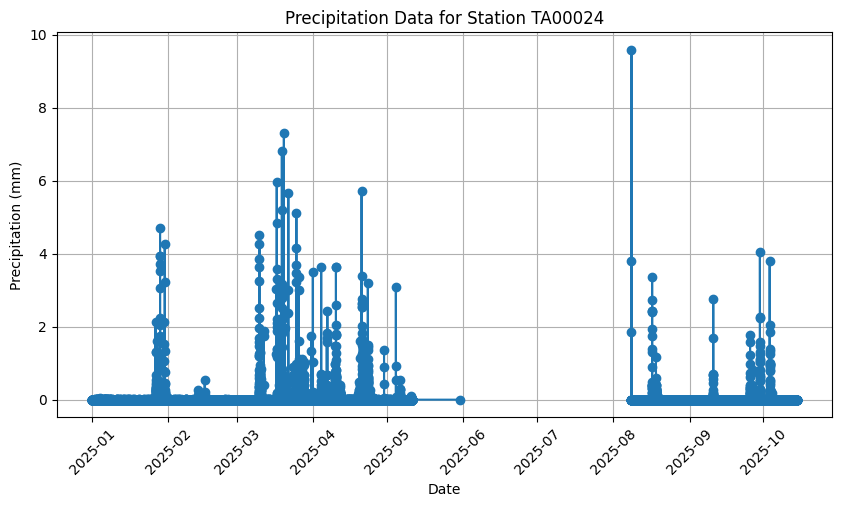

Station Code: TA00024
Data Range: 0.0 mm to 9.587 mm
Number of Records: 56618


In [47]:
# @title ### 6b) Check the range of the data and plot any of the stations randomly
# @markdown Rerun this cell to visualise the next random station in the region <br>
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

plot_stations_data_randomly(region_precip_data)

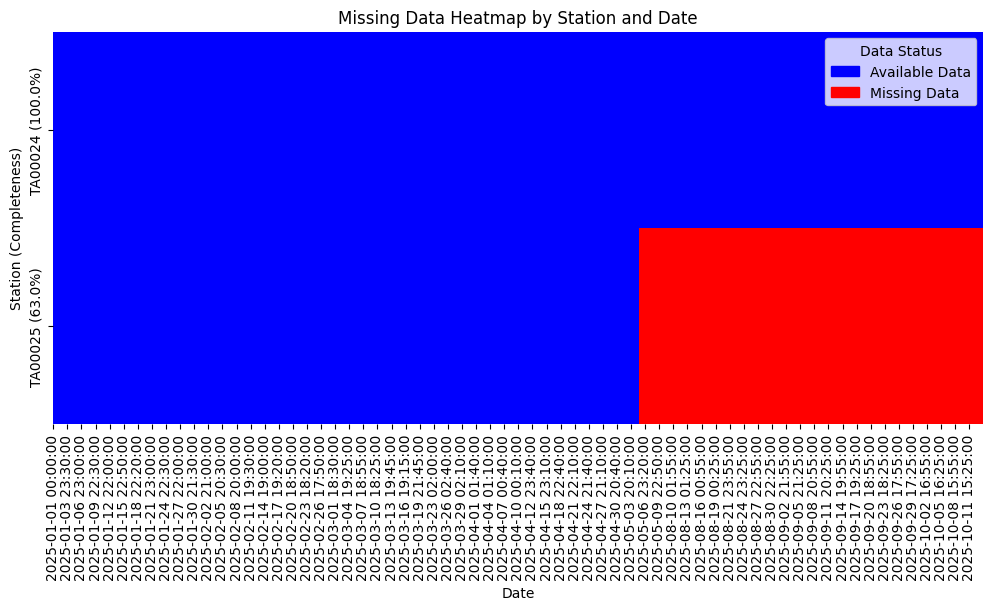

In [48]:
# @title ### 6c) Visualise missing data for each station {"display-mode":"form"}
# @markdown The generated chart shows the available data on y axis and a heatmap of available
# Get the stations with missing data
# missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
# # print(f"Stations with missing data: {missing_stations}")
# # drop stations with all missing data
# region_precip_data = region_precip_data.dropna(how='all', axis=1)
# region_precip_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# # Get the stations with missing data
# missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
# print(f"Stations with missing data: {missing_stations}")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches

# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in region_precip_data.columns if len(i.split('_')) > 1]
region_precip_data_filtered = region_precip_data.drop(columns=multiple_sensors)

# Calculate missing data percentage per station over time
missing_data = region_precip_data_filtered.isnull().T
missing_data.columns = list(missing_data.columns.tz_localize(None).astype(str))

# Calculate overall completeness percentage for each station
overall_completeness = (1 - region_precip_data_filtered.isnull().mean(axis=0)) * 100

# Sort stations by overall completeness in descending order
sorted_stations = overall_completeness.sort_values(ascending=False).index
missing_data_sorted = missing_data.loc[sorted_stations]

# Determine the number of stations to dynamically adjust height
num_stations = len(missing_data_sorted)
# Define a base height and an additional height per station
base_height = 5  # Base height in inches
height_per_station = 0.05 # Additional height per station in inches
fig_height = base_height + num_stations * height_per_station

# Create a custom colormap: Blue for non-missing (False), Red for missing (True)
cmap = matplotlib.colors.ListedColormap(['blue', 'red'])

plt.figure(figsize=(12, fig_height))
# Use the custom colormap and specify levels for the two colors, and remove the legend
sns.heatmap(missing_data_sorted, cbar=False, cmap=cmap, vmin=0, vmax=1)

# Create legend patches
blue_patch = mpatches.Patch(color='blue', label='Available Data')
red_patch = mpatches.Patch(color='red', label='Missing Data')

# Add legend to the plot
plt.legend(handles=[blue_patch, red_patch], title="Data Status", loc='upper right')

# Update y-axis labels to include completeness percentage
ax = plt.gca()
y_labels = [f"{label.get_text()} ({overall_completeness.loc[label.get_text()]:.1f}%)" for label in ax.get_yticklabels()]
ax.set_yticklabels(y_labels)

plt.title('Missing Data Heatmap by Station and Date')
plt.xlabel('Date')
plt.ylabel('Station (Completeness)')
plt.xticks(rotation=90) # Rotate x-axis labels
plt.show()

In [60]:
# @title ### 6d) Ground Satellite Map visual comparison
from utils.plotting_point import point_plot

import xarray as xr

# Weather points
# Slice the resampled ground station data to match the number of time steps in chirps_ds
num_chirps_timesteps = len(chirps_ds.time)
ground_data_for_plot = region_precip_data.resample('5D').sum().iloc[:num_chirps_timesteps]


html_anim = point_plot(
    ground_data_for_plot,
    region_metadata,
    variable_name="Rainfall (mm)", # This is the point data variable name
    metadata_columns=['code', 'lat', 'lon'],
    cmap="plasma",
    grid_da=chirps_ds,
    grid_cmap="coolwarm",
    grid_alpha=0.5,
    fig_title="Station Precipitation vs CHIRPS Background",
    grid_da_var='precipitation'
)

html_anim

# **Step 7: Aggregate the Ground data to Pentads**

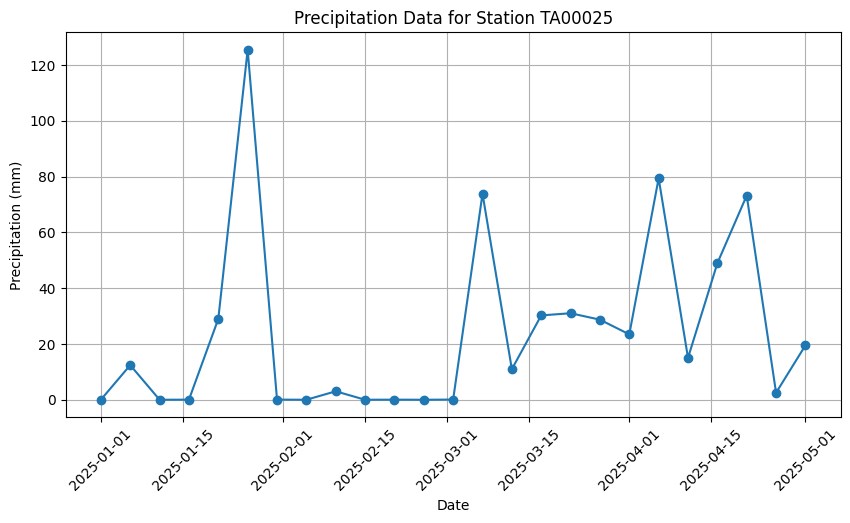

Station Code: TA00025
Data Range: 0.0 mm to 125.45100000000001 mm
Number of Records: 57


In [52]:
# @title Aggregate station rain to pentads to match CHIRPS. {"display-mode":"form"}
# @markdown In order to match CHIRPS and how it is extracted we will aggregate the data to pentads (5 days)
region_precip_pentad = rd.aggregate_variables(region_precip_data, freq='5D', method='sum')[:-1]
plot_stations_data_randomly(region_precip_pentad)


# **Step 8: Build CHIRPS Nearest data for the ground stations**

In [70]:
# @title ### At this step we are building the CHIRPS station dataset by using the station metadata (latitude and longitude) to get the nearest value of CHIRPS
# filter to the required stations
req_stations = region_precip_pentad.columns.tolist()

region_metadata = region_metadata[region_metadata['code'].isin(req_stations)]

def build_chirps_from_stations(chirps_ds, stations_metadata, k=NEIGHBORHOOD):
    """
    Build CHIRPS station dataset by sampling CHIRPS values at station locations.

    Parameters
    ----------
    chirps_ds : xarray.Dataset
        CHIRPS dataset with coordinates ('x', 'y', 'time')
    stations_metadata : pd.DataFrame
        Must contain columns ['code', 'lat', 'lon']
    k : int, optional
        Number of nearest CHIRPS grid points to average. Default is 1 (just nearest pixel).
    """
    import numpy as np
    import pandas as pd

    all_stations_data = {}

    # Extract coordinate arrays for CHIRPS grid
    chirps_lons = chirps_ds['x'].values
    chirps_lats = chirps_ds['y'].values

    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = row['lat']
        lon = row['lon']

        # Compute distances (simple Euclidean approximation — fine for small areas)
        dist = np.sqrt((chirps_lats[:, None] - lat)**2 + (chirps_lons[None, :] - lon)**2)
        dist_flat = dist.ravel()

        # Get the k nearest pixel indices
        nearest_indices = np.argsort(dist_flat)[:k]

        # Convert flat indices back to 2D (lat, lon)
        lat_idx, lon_idx = np.unravel_index(nearest_indices, dist.shape)

        # Extract data for those k pixels
        da_values = [chirps_ds.precipitation.isel(y=lat_i, x=lon_i) for lat_i, lon_i in zip(lat_idx, lon_idx)]

        # Compute mean across k nearest points
        station_da = sum(da_values) / len(da_values)
        station_df = station_da.to_dataframe().rename(columns={'precipitation': station_code})

        all_stations_data[station_code] = station_df[station_code]

    combined_df = pd.DataFrame(all_stations_data)
    return combined_df


chirps_stations = build_chirps_from_stations(chirps_ds, region_metadata)
# plot_stations_data_randomly(chirps_stations)
chirps_stations

,TA00024,TA00025
time,,
2025-04-01,23.232340,37.689632
2025-04-06,56.992004,65.047417
2025-04-11,23.483887,30.135550
2025-04-16,27.809088,34.402927
2025-04-21,40.880917,62.265427
2025-04-26,21.428797,16.667511
2025-05-01,13.448254,16.920547
2025-05-06,29.113573,48.037876
2025-05-11,25.660810,55.624935


# **Step 9: Visualise CHIRPS vs the Ground stations**

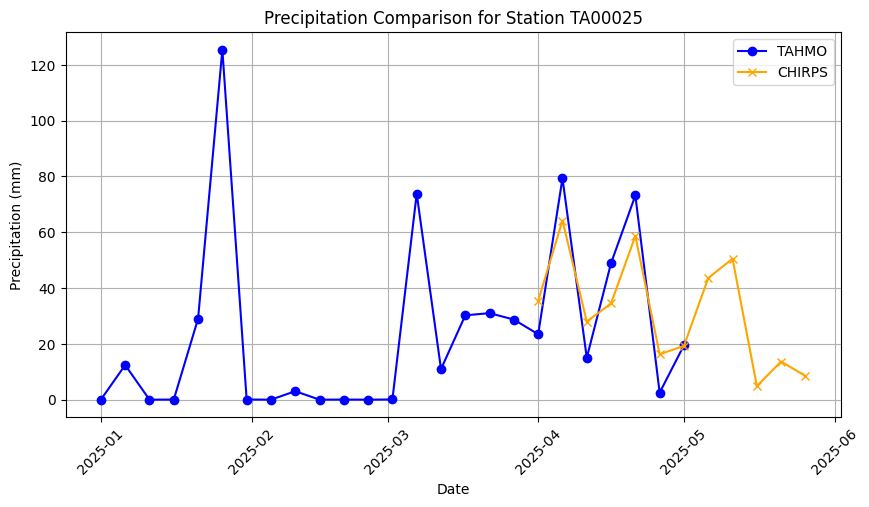

Station Code: TA00025
TAHMO Data Range: 0.0 mm to 125.45100000000001 mm
CHIRPS Data Range: 4.876615524291992 mm to 64.20915985107422 mm
Number of TAHMO Records: 57
Number of CHIRPS Records: 12


In [55]:
# @title ### Plot the CHIRPS data and TAHMO equivalents for a random station
# @markdown Every single time we run this cell we get to visualise the CHIRPS v Ground data comparison for a different station within the region
def plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations, station_code=None):
    if station_code is None:
      import random
      station_codes = eac_pentad.columns.intersection(chirps_stations.columns).tolist()
      if not station_codes:
          print("No common stations between EAC pentad data and CHIRPS data.")
          return

      random_station = random.choice(station_codes)
    else:
      random_station = station_code

    tahmo_data = eac_pentad[random_station]
    chirps_data = chirps_stations[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(tahmo_data.index, tahmo_data.values, marker='o', label='TAHMO', color='blue')
    plt.plot(chirps_data.index, chirps_data.values, marker='x', label='CHIRPS', color='orange')
    plt.title(f'Precipitation Comparison for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"TAHMO Data Range: {tahmo_data.min()} mm to {tahmo_data.max()} mm")
    print(f"CHIRPS Data Range: {chirps_data.min()} mm to {chirps_data.max()} mm")
    print(f"Number of TAHMO Records: {len(tahmo_data)}")
    print(f"Number of CHIRPS Records: {len(chirps_data)}")

plot_chirps_vs_tahmo_randomly(region_precip_pentad, chirps_stations)

# **Step 10: Compute station confidence scores**

In [73]:
# @title ### 10a) Run this cell to compute station scores
# @title Confidence Score Formula
# @markdown ### **Confidence Score Formula**
# @markdown For each station, the confidence score is computed as:
# @markdown
# @markdown $$
# @markdown \text{Confidence Score} = 100 \times \big(0.3 \cdot C \;+\; 0.3 \cdot r \;+\; 0.2 \cdot (1 - O) \;+\; 0.2 \cdot(1- b) \big)
# @markdown $$
# @markdown
# @markdown Where:
# @markdown - $C = 1 -$ (missing fraction of observations), i.e. **completeness**
# @markdown - $r =$ Spearman correlation coefficient between observed and CHIRPS pentads
# @markdown - $O =$ fraction of outliers (observed values < 0)
# @markdown - $b =$ Bias Significance - paired $t$-test between observed and simulated values (significant if $p < 0.05$)
# @markdown
# @markdown ---
# @markdown
# @markdown **Additional metrics per station:**
# @markdown
# @markdown - **RMSE**
# @markdown $$
# @markdown \text{RMSE} = \sqrt{\frac{1}{n} \sum (obs - sim)^2}
# @markdown $$
# @markdown
# @markdown - **Adjusted confidence score**
# @markdown $$
# @markdown \text{Adjusted Confidence Score} = \text{Confidence Score} - \text{RMSE}
# @markdown $$
# @markdown

from scipy.stats import pearsonr, ttest_rel
# spearman correlation
from scipy.stats import spearmanr

def compute_station_scores(eac_pentad, chirps_stations): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    # get the union stations
    stations = eac_pentad.columns.intersection(chirps_stations.columns)
    if stations.empty:
        print("No common stations between EAC pentad data and CHIRPS data.")
        return None
    # choose only the matching dates by checking the index
    union_dates = eac_pentad.index.intersection(chirps_stations.index)
    # print()
    eac_pentad = eac_pentad.loc[union_dates]
    chirps_stations = chirps_stations.loc[union_dates]
    scores = []
    for station in stations:
        obs = eac_pentad[station]
        sim = chirps_stations[station]

        if CORR_METHOD.lower()=='pearson':
            corr, _ = pearsonr(obs, sim)
        else:
            corr, _ = spearmanr(obs, sim)

        # Compute metrics
        error = rmse(obs, sim)
        t_stat, p_val = ttest_rel(obs, sim)
        bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
        completeness = 1 - obs.isna().mean()
        outlier_rate = (obs < 0).mean()
        #         confidence_score = 100 * (0.4 * completeness + 0.4 * np.nan_to_num(r, nan=0) + 0.2 * (1 - outlier_rate)) previous

        confidence_score = 100 * (0.3 * completeness + 0.3 * np.nan_to_num(corr, nan=0) + 0.2 * (1 - outlier_rate)+ 0.2*(1-p_val))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                f'{CORR_METHOD}_r': corr,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

# @title RMSE
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))


station_scores = compute_station_scores(region_precip_pentad, chirps_stations)
# to the confidence scores subtract the rmse
station_scores['adjusted_confidence_score'] = station_scores['confidence_score'] - station_scores['rmse']
station_scores.sort_values(by='adjusted_confidence_score', ascending=False).head(20)

# save the stations with the confidence scores
station_scores.to_csv(f'{dir_path}/station_scores_{region_query}.csv', index=False)


'''
1. Compute the RMSE
2. Compute the Pearson correlation coefficient
3. Compute the ttest for bias
    bias significance (p<0.05) ['Significant' if p_val < 0.05 else 'Not Significant']
4. Compute completeness (% of non-missing values)
        completeness = 1 - g['station_pentad'].isna().mean()
        outlier_rate = (g['station_pentad']<0).mean()
5. confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate))
'''
station_scores.sort_values(by='confidence_score', ascending=False)


,station_id,confidence_score,spearman_r,rmse,bias_signif,completeness,outlier_rate,adjusted_confidence_score
0,TA00024,NaN,NaN,19.390561,Not Significant,0.833333,0.0,NaN
1,TA00025,NaN,NaN,12.957432,Not Significant,0.583333,0.0,NaN


In [74]:
# @title 10b) Export the confidence scores results to excel file
from google.colab import files
print('Exporting station scores to Excel ...')
station_scores.to_excel(f'{dir_path}/station_scores_{region_query}.xlsx', index=False)
files.download(f'{dir_path}/station_scores_{region_query}.xlsx')

# print('✅ Su')

Exporting station scores to Excel ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
# @title 10c) Visualise station confidence

import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

def plot_station_vs_chirps_and_confidence_interactive(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    scatter_color="#3366cc",
    width=900, # Add width parameter
    height=600 # Add height parameter
):
    """
    Scatter: single color (no category legend)
    Geo map: always shows High / Medium / Low categories
    Returns:
      m_long, score_map, scatter_fig, map_fig
    """
    # -------- 1. Build long paired dataset --------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame({'station_pentad': s_obs, 'sat_pentad': s_sat}).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            rows.append(pair)
    if not rows:
        print("No stations with sufficient paired data.")
        return None, None, None, None
    m_long = pd.concat(rows, axis=0).reset_index(drop=True)

    # -------- 2. Always compute classification for map --------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify_fn(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify_fn)
    # enforce category ordering even if some missing
    cls_order = ['High','Medium','Low']
    sc['class'] = pd.Categorical(sc['class'], categories=cls_order, ordered=True)

    # -------- 3. Merge with metadata --------
    meta = metadata_df.rename(columns={'code':'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left').dropna(subset=['lat','lon'])
    score_map['class'] = pd.Categorical(score_map['class'], categories=cls_order, ordered=True)

    # -------- 4. Merge scores into long paired --------
    # Added 'spearman_r' to the list of columns to merge
    merge_cols = ['station_id','confidence_score','class','spearman_r','rmse','completeness','outlier_rate','bias_signif']
    existing = [c for c in merge_cols if c in sc.columns]
    m_long = m_long.merge(sc[existing], on='station_id', how='left')

    # -------- 5. Scatter (single color) --------
    lim_max = float(max(m_long['station_pentad'].max(), m_long['sat_pentad'].max()))
    hover_data = {
        'station_id': True,
        'time': True,
        'station_pentad': ':.2f',
        'sat_pentad': ':.2f',
        'confidence_score': ':.1f',
        'class': True,
        'spearman_r': ':.3f', # Ensure this is correctly referenced
        'rmse': ':.2f',
        'completeness': ':.2f',
        'outlier_rate': ':.3f',
        'bias_signif': True
    }
    scatter_fig = px.scatter(
        m_long,
        x='station_pentad',
        y='sat_pentad',
        title=f"{country_label}: Station vs CHIRPS (Pentad)",
        hover_data=hover_data,
        labels={'station_pentad':'Station (mm)','sat_pentad':'CHIRPS (mm)'},
        width=width, # Pass width to scatter plot
        height=height # Pass height to scatter plot
    )
    scatter_fig.update_traces(marker=dict(color=scatter_color))
    scatter_fig.update_layout(showlegend=False)
    scatter_fig.add_trace(
        go.Scatter(
            x=[0, lim_max],
            y=[0, lim_max],
            mode='lines',
            line=dict(dash='dash', color='black'),
            name='1:1'
        )
    )
    scatter_fig.update_xaxes(constrain='domain')
    scatter_fig.update_yaxes(scaleanchor=None)

        # -------- 6. Geo Map (with categories, OSM basemap) --------
    palette = {'High':'green','Medium':'orange','Low':'red'}
    map_fig = px.scatter_mapbox(
        score_map,
        lat='lat',
        lon='lon',
        color='class',
        color_discrete_map=palette,
        hover_name='station_id',
        hover_data={
            'confidence_score': ':.1f',
            'spearman_r': ':.3f', # Ensure this is correctly referenced
            'rmse': ':.2f',
            'completeness': ':.2f',
            'outlier_rate': ':.3f',
            'bias_signif': True,
            'lat': ':.3f',
            'lon': ':.3f'
        },
        title=f"{country_label} Station Confidence",
        zoom=5,
        height=height,
        width=width
    )
    # map_fig.update_layout(
    #     legend_title_text='Confidence',
    #     mapbox_style="open-street-map"
    # )
    map_fig.update_layout(
        mapbox_style="open-street-map",
        legend_title_text=f"Confidence<br>(High ≥ {high_thr}, Low < {low_thr})"
    )

    if {'lat','lon'}.issubset(score_map.columns) and len(score_map):
        lat_min, lat_max = score_map['lat'].min(), score_map['lat'].max()
        lon_min, lon_max = score_map['lon'].min(), score_map['lon'].max()
        lat_center = (lat_min + lat_max) / 2
        lon_center = (lon_min + lon_max) / 2
        map_fig.update_layout(
            mapbox_center={"lat": lat_center, "lon": lon_center},
            mapbox_zoom=5
        )


    return m_long, score_map, scatter_fig, map_fig

# Get the user to input the high and low threshold
time.sleep(1)
high_thr = int(High_confidence_threshold)
low_thr = int(Low_confidence_threshold)

print(f"High threshold: {high_thr}")
print(f"Low threshold: {low_thr}")
import time
time.sleep(2)

m_pairs, score_with_meta, scatter_fig, map_fig = plot_station_vs_chirps_and_confidence_interactive(
    region_precip_pentad,
    chirps_stations,
    station_scores,
    region_metadata,
    country_label=f"{region_query}",
    high_thr=high_thr,
    low_thr=low_thr,
    scatter_color="#3366cc",
    width=900, # Pass width to the function call
    height=600 # Pass height to the function call
)

if scatter_fig is not None:
    scatter_fig.show()
if map_fig is not None: # Also check if map_fig is not None before showing
    map_fig.show()

High threshold: 70
Low threshold: 30
